In [49]:
import sys
import os
import seaborn as sns
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [14]:
# Update the connection details with your own values
host = 'localhost'
port = '5432'
database = 'postgres'
user = 'postgres'
password = 'ab1234'

In [30]:
db = PostgresConnection(dbname='telecom', user='postgres', password='ab1234')
db.connect()

# Example query
query = "SELECT * FROM xdr_data"
result = db.execute_query(query)

# Convert the result to a Pandas DataFrame
df = pd.DataFrame(result, columns=[desc[0] for desc in db.cursor.description])
print(df.head())  # Display the first few rows of the DataFrame

# Close the connection when done
db.close_connection()

Connected to PostgreSQL database!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...         

In [31]:
# Aggregate the engagement metrics per customer id (MSISDN)
engagement_metrics = df.groupby('MSISDN/Number').agg({
    'Start': 'count',  # sessions frequency
    'Dur. (ms).1': 'sum',  # session duration
    'Total UL (Bytes)': 'sum',  # total upload traffic
    'Total DL (Bytes)': 'sum'  # total download traffic
})
engagement_metrics.columns = ['Sessions Frequency', 'Session Duration', 'Total Upload Traffic', 'Total Download Traffic']

In [33]:
# Report the top 10 customers per engagement metric
top_10_sessions_freq = engagement_metrics.sort_values('Sessions Frequency', ascending=False).head(10)
top_10_session_dur = engagement_metrics.sort_values('Session Duration', ascending=False).head(10)
top_10_total_upload = engagement_metrics.sort_values('Total Upload Traffic', ascending=False).head(10)
top_10_total_download = engagement_metrics.sort_values('Total Download Traffic', ascending=False).head(10)

# Display the top 10 customers per engagement metric
print("Top 10 Customers per Sessions Frequency:")
print(top_10_sessions_freq)
print("\nTop 10 Customers per Session Duration:")
print(top_10_session_dur)
print("\nTop 10 Customers per Session Upload Traffic:")
print(top_10_total_upload)
print("\nTop 10 Customers per Session Download Traffic:")
print(top_10_total_download)

Top 10 Customers per Sessions Frequency:
               Sessions Frequency  Session Duration  Total Upload Traffic  \
MSISDN/Number                                                               
3.362632e+10                   18      8.791937e+09           669650721.0   
3.361489e+10                   17      9.966906e+09           689483001.0   
3.362578e+10                   17      1.855376e+10           729577380.0   
3.365973e+10                   16      4.035436e+09           624260321.0   
3.367588e+10                   15      4.865954e+09           581568792.0   
3.376054e+10                   15      9.279442e+09           703478581.0   
3.366716e+10                   13      8.744922e+09           566326364.0   
3.360452e+10                   12      5.207995e+09           391775856.0   
3.376041e+10                   12      5.321674e+09           521518890.0   
3.360313e+10                   12      6.287767e+09           435587631.0   

               Total Download Traf

In [35]:
# Normalize each engagement metric
normalized_engagement_metrics = (engagement_metrics - engagement_metrics.min()) / (engagement_metrics.max() - engagement_metrics.min())

In [36]:
# Run k-means clustering (k=3) on normalized engagement metrics

kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(normalized_engagement_metrics)

In [37]:
# Add cluster labels to the engagement metrics dataframe
engagement_metrics['Cluster'] = clusters

In [38]:
# Compute the minimum, maximum, average, and total non-normalized metrics for each cluster
cluster_metrics = engagement_metrics.groupby('Cluster').agg({
    'Sessions Frequency': ['min', 'max', 'mean', 'sum'],
    'Session Duration': ['min', 'max', 'mean', 'sum'],
    'Total Upload Traffic': ['min', 'max', 'mean', 'sum'],
    'Total Download Traffic': ['min', 'max', 'mean', 'sum']
})

In [39]:
# Aggregate user total traffic per application
application_traffic = df.groupby('MSISDN/Number').agg({
    'Social Media DL (Bytes)': 'sum',
    'Social Media UL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Google UL (Bytes)': 'sum',
    'Email DL (Bytes)': 'sum',
    'Email UL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Youtube UL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Netflix UL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Gaming UL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum',
    'Other UL (Bytes)': 'sum'
})

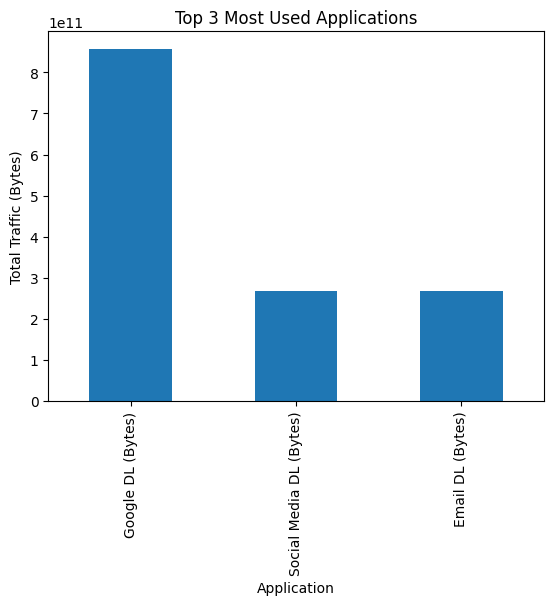

In [40]:
# Derive the top 10 most engaged users per application
top_10_social_media = application_traffic.sort_values('Social Media DL (Bytes)', ascending=False).head(10)
top_10_google = application_traffic.sort_values('Google DL (Bytes)', ascending=False).head(10)
top_10_email = application_traffic.sort_values('Email DL (Bytes)', ascending=False).head(10)

# Plot the top 3 most used applications
top_3_applications = application_traffic[['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)']].sum().nlargest(3)
top_3_applications.plot(kind='bar', xlabel='Application', ylabel='Total Traffic (Bytes)', title='Top 3 Most Used Applications')

plt.show()

In [45]:
# Normalize the Data
scaler = StandardScaler()
scaled_engagement_metrics = scaler.fit_transform(engagement_metrics)

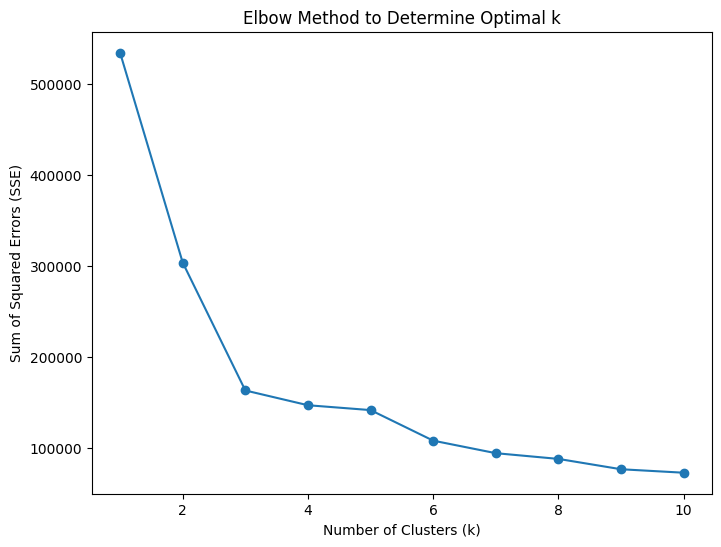

In [46]:
# Use the Elbow Method to find the optimal k
sse = []  # List to store the sum of squared errors for each k
k_values = range(1, 11)  # We'll check k from 1 to 10

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_engagement_metrics)
    sse.append(kmeans.inertia_)  # Inertia is the sum of squared distances to the nearest cluster center

# Plot the Elbow Method results
plt.figure(figsize=(8, 6))
plt.plot(k_values, sse, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

In [47]:
# Apply K-Means Clustering with the optimal k (choose based on elbow plot)
optimal_k = 4  # Let's assume the elbow method suggests k=4 (you'll determine this from the plot)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_engagement_metrics)

# Add cluster labels to the original data
application_traffic['Cluster'] = clusters

# Interpret the results
# You can group by clusters and analyze the engagement metrics per cluster
cluster_summary = application_traffic.groupby('Cluster').mean()
print(cluster_summary)

         Social Media DL (Bytes)  Social Media UL (Bytes)  Google DL (Bytes)  \
Cluster                                                                        
0                   1.847018e+06             33851.173954       5.898926e+06   
1                   1.810119e+06             33110.013827       5.814874e+06   
2                   7.568456e+06            139141.993574       2.445977e+07   
3                   3.873582e+06             71159.145507       1.237838e+07   

         Google UL (Bytes)  Email DL (Bytes)  Email UL (Bytes)  \
Cluster                                                          
0             2.109008e+06      1.850436e+06      4.795588e+05   
1             2.071750e+06      1.807336e+06      4.720616e+05   
2             8.781667e+06      7.613397e+06      1.985535e+06   
3             4.430535e+06      3.842886e+06      1.006759e+06   

         Youtube DL (Bytes)  Youtube UL (Bytes)  Netflix DL (Bytes)  \
Cluster                                            

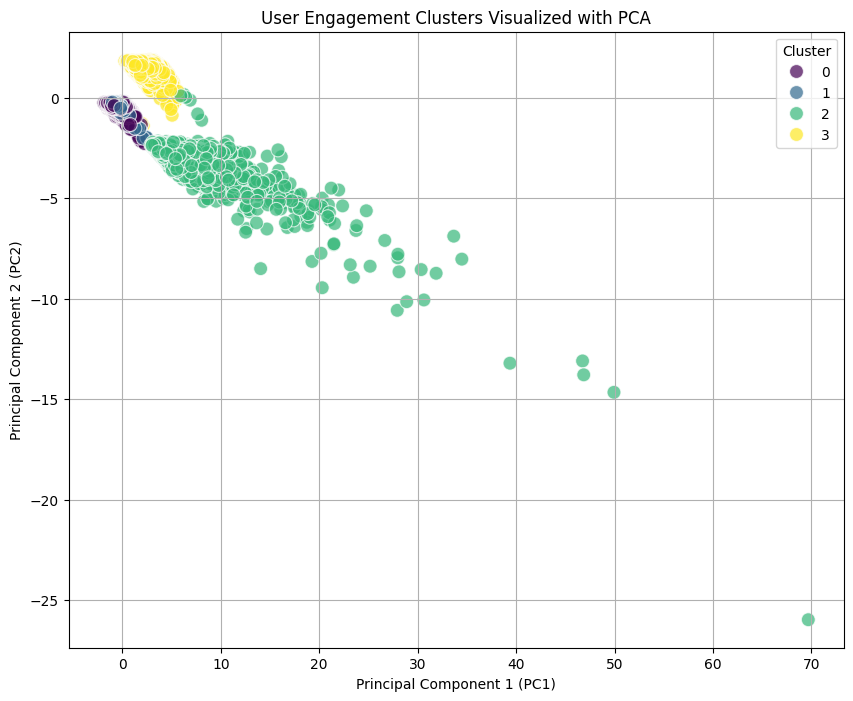

In [50]:
# Assuming k-means is already applied with the optimal k (let's say k=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_engagement_metrics)

# Apply PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
pca_engagement = pca.fit_transform(scaled_engagement_metrics)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=pca_engagement, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Plot the clusters using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='viridis', data=pca_df, s=100, alpha=0.7)

plt.title('User Engagement Clusters Visualized with PCA')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.grid(True)
plt.show()